In [2]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

In [3]:
categories = [
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'alt.atheism',
    'soc.religion.christian'
]

dataset = fetch_20newsgroups(subset='train', categories=categories,
                             shuffle=True, remove=('headers', 'footers', 'quotes'))

In [4]:
dataset.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [5]:
dataset['data'][0]

"\nThey tried their best not to show it, believe me. I'm surprised they\ncouldn't find a sprint car race (mini cars through pigpens, indeed!)\non short notice.\n\nGeorge"

In [6]:
df = pd.DataFrame(dataset.data, columns=["corpus"])

print(df.head())

                                              corpus
0  \nThey tried their best not to show it, believ...
1  \nStankiewicz?  I doubt it.\n\nKoufax was one ...
2  \n[deletia- and so on]\n\nI seem to have been ...
3  Excuse the sheer newbieness of this post, but ...
4  ==============================================...


In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

In [8]:
def preprocess(text, n):

    # To lower case and tokenization
    tokens = word_tokenize(text.lower())

    # Stop word and punctuation removal
    filtered_tokens = [token for token in tokens if token.isalpha() and (token not in stopwords.words('english'))]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    if n <= 1:
        return lemmatized_tokens
    
    # NGram generation
    ngram_set = []
    
    for i in range(1, n + 1):
        processed_text = ngrams(lemmatized_tokens, i)
        ngram_set.extend([' '.join(grams) for grams in processed_text])

    return ngram_set

In [9]:
df['corpus'] = df['corpus'].apply(preprocess, args=(1,))

In [10]:
print(df.loc[0][0])

['tried', 'best', 'show', 'believe', 'surprised', 'could', 'find', 'sprint', 'car', 'race', 'mini', 'car', 'pigpen', 'indeed', 'short', 'notice', 'george']


In [11]:
from collections import Counter
from collections import defaultdict

In [12]:
def build_dictionary(df, attribute):
    dictionary = defaultdict(dict)
    
    for idx, record in enumerate(df[attribute]):
        counter = Counter(record)

        for token in counter:
            dictionary[token][idx] = counter[token]
    
    return dictionary

In [13]:
dictionary = build_dictionary(df, 'corpus')

print(list(dictionary.keys())[:10])
print()
print('Number of distinct tokens:', len(dictionary))
print('Number of records:', len(df))
print()
print('Number of data:', "{:,}".format(len(dictionary) * len(df)))

['tried', 'best', 'show', 'believe', 'surprised', 'could', 'find', 'sprint', 'car', 'race']

Number of distinct tokens: 27574
Number of records: 3451

Number of data: 95,157,874


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
df['corpus'] = df['corpus'].apply(lambda token_list: ' '.join(token_list))

In [16]:
df['corpus'].loc[0]

'tried best show believe surprised could find sprint car race mini car pigpen indeed short notice george'

In [17]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df['corpus'])
X

<3451x8505 sparse matrix of type '<class 'numpy.float64'>'
	with 184857 stored elements in Compressed Sparse Row format>

In [18]:
X.toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
X.toarray()[0].sum()

3.4433303827468618

In [20]:
from sklearn.cluster import KMeans

In [21]:
# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=6, n_init='auto', random_state=101)

# fit the model
kmeans.fit(X)

# store cluster labels in a variable
clusters = kmeans.labels_

In [22]:
[c for c in clusters[:10]]

[4, 4, 3, 0, 4, 4, 2, 1, 0, 1]

In [23]:
from sklearn.decomposition import PCA

In [24]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)

# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())

# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [25]:
# assign clusters and pca vectors to our dataframe 
df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

In [26]:
df

,corpus,cluster,x0,x1
0,tried best show believe surprised could find s...,4,0.004301,-0.006190
1,stankiewicz doubt koufax one two jewish hofs h...,4,0.036359,0.050222
2,seem rather unclear asking please show effecti...,3,0.054569,-0.102654
3,excuse sheer newbieness post looking decent pa...,0,-0.169985,-0.056381
4,,4,-0.023557,0.023106
...,...,...,...,...
3446,dictionary available could gain first hand kno...,4,0.017626,0.004526
3447,sorry disappoint red wing earned victory easil...,2,0.044475,0.227404
3448,anyone tell find mpeg viewer either do window ...,1,-0.167084,-0.049253
3449,,4,-0.023557,0.023106


In [27]:
import numpy as np

In [28]:
def get_top_keywords(X, n_terms, vectorizer):
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(', '.join([terms[t] for t in np.argsort(r)[-n_terms:]]))
        # for each row of the dataframe, find the n terms that have the highest tf idf score

In [29]:
get_top_keywords(X, 70, vectorizer)


Cluster 0
number, routine, display, support, look, point, address, convert, data, greatly, tiff, via, access, version, line, one, pc, work, want, algorithm, also, source, vga, mail, ftp site, book, good, animation, anybody, could, computer, mode, find, card, system, using, email, max max, appreciated, site, get, library, info, like, use, thanks advance, available, package, looking, code, need, color, anyone know, max, please, ftp, advance, information, software, would, hi, help, know, anyone, format, file, program, graphic, image, thanks

Cluster 1
tried, ati, driver window, found, site, advance, want, well, think, icon, ca, manager, used, do window, cica, hi, cview, ftp, copy, looking, nt, character, available, utility, would, drive, new, diamond, set, please, find, try, pc, microsoft, color, anybody, help, also, application, like, machine, one, need, memory, mouse, screen, disk, video, running, printer, system, mode, get, run, work, anyone, directory, know, thanks, using, font, vers

In [30]:
# map clusters to appropriate labels 
cluster_map = {0: "miscellaneous", 1: "tech", 2: "religion", 3: "c3", 4: "c4", 5: "c5"}

# apply mapping
df['cluster'] = df['cluster'].map(cluster_map)

In [31]:
df

,corpus,cluster,x0,x1
0,tried best show believe surprised could find s...,c4,0.004301,-0.006190
1,stankiewicz doubt koufax one two jewish hofs h...,c4,0.036359,0.050222
2,seem rather unclear asking please show effecti...,c3,0.054569,-0.102654
3,excuse sheer newbieness post looking decent pa...,miscellaneous,-0.169985,-0.056381
4,,c4,-0.023557,0.023106
...,...,...,...,...
3446,dictionary available could gain first hand kno...,c4,0.017626,0.004526
3447,sorry disappoint red wing earned victory easil...,religion,0.044475,0.227404
3448,anyone tell find mpeg viewer either do window ...,tech,-0.167084,-0.049253
3449,,c4,-0.023557,0.023106


In [32]:
from matplotlib import pyplot as plt
import seaborn as sns

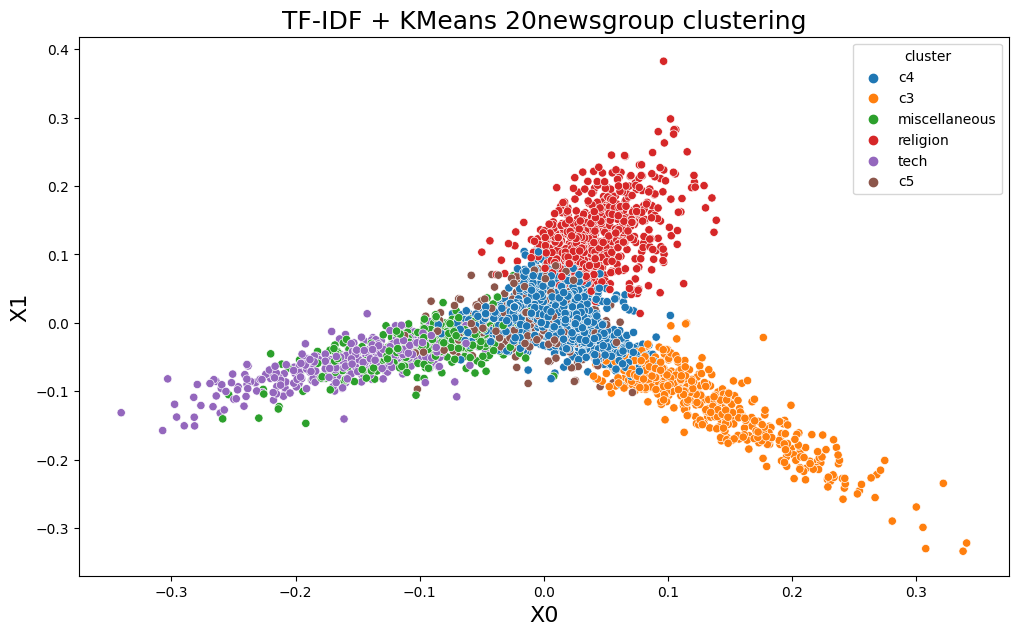

In [33]:
# set image size
plt.figure(figsize=(12, 7))

# set a title
plt.title("TF-IDF + KMeans 20newsgroup clustering", fontdict={"fontsize": 18})

# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})

# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster')

plt.show()